
# Walk-Wave Sequence Analysis


## 0. Importing libraries and FRVRS logs data frame and creating voices capture data frame

In [2]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [3]:

from notebook_utils import NotebookUtilities
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [4]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)


In [25]:

fns_list = [fn for fn in nu.get_dir_tree('pysan', contains_str=None, not_contains_str=None, verbose=False) if (fn.count('.') < 3)]
defined_list = []
with open('Walk-Wave Sequence Analysis.ipynb', 'r') as f:
    lines_list = f.read().split('\n')
    for line in lines_list:
        line = line.lstrip()
        if line.startswith('"def '):
            fn = line.split('"')[1].split(' ')[1].split('(')[0]
            if (fn not in ['replace_consecutive_elements', 'convert_strings_to_integers']): defined_list.append(fn)
fn_str = f"\\.({'|'.join(defined_list)})$"
fn_regex = re.compile(fn_str)
for fn in fns_list:
    if fn_regex.search(fn):
        submodules_list = fn.split('.')
        from_str = '.'.join(list(submodules_list[:-1]))
        print(f'from {from_str} import {submodules_list[-1]}')

from pysan import get_transition_matrix
from pysan import plot_sequence
from pysan import plot_sequence_1d
from pysan import plot_transition_matrix
from pysan.statistics import get_ndistinct_subsequences


In [55]:

# 16:20:44, 17.79
import humanize
from datetime import timedelta

humanize.precisedelta(timedelta(seconds=20*5_000))

'1 day, 3 hours, 46 minutes and 40 seconds'

In [54]:

import datetime

# Total iteration time
total_iteration_time = "16:20:44"

# Seconds per iteration
seconds_per_iteration = 17.79

# Convert the total iteration time to seconds
total_iteration_time_in_seconds = int(total_iteration_time.split(":")[0]) * 3600 + int(total_iteration_time.split(":")[1]) * 60 + int(total_iteration_time.split(":")[2])

# Calculate the number of iterations
number_of_iterations = total_iteration_time_in_seconds / seconds_per_iteration

# Print the number of iterations
print(f"Number of iterations: {number_of_iterations}")

Number of iterations: 3307.70095559303



## How many patients are treated between the walk and wave commands?

In [5]:

def replace_consecutive_elements(actions_list, element='PATIENT_ENGAGED'):
    '''
    Replaces consecutive elements in a list with a count of how many there are in a row.
    
    Args:
        list1: A list of elements.
        element: The element to replace consecutive occurrences of.
    
    Returns:
        A list with the consecutive elements replaced with a count of how many there are in a row.
    '''
    result = []
    count = 0
    for i in range(len(actions_list)):
        if (actions_list[i] == element): count += 1
        else:
            if (count > 0): result.append(f'{element} x{str(count)}')
            result.append(actions_list[i])
            count = 0
    
    # Handle the last element
    if (count > 0): result.append(f'{element} x{str(count)}')
    
    return(result)

In [6]:

# Visualize the number of voices captured between walk and wave
columns_list = ['voice_command_message', 'action_type']

# Loop through each unique file and scene combination
time_groups_dict = {}
consecutive_time_groups_dict = {}
for (session_uuid, time_group), df1 in nu.get_session_groupby(extra_column='time_group'):
    
    # Get all the engaged, walk, and wave events in this scene
    mask_series = df1.voice_command_message.isin(['walk to the safe area', 'wave if you can'])
    mask_series |= (df1.action_type == 'PATIENT_ENGAGED')
    
    # Print out the results
    df2 = df1[mask_series][columns_list]#.sort_values('elapsed_time')
    if df2.shape[0]:
        key = (session_uuid, time_group)
        actions_list = []
        for row_index, row_series in df2.iterrows():
            action_type = row_series.action_type
            if (action_type == 'PATIENT_ENGAGED'): actions_list.append('PATIENT_ENGAGED')
            else: actions_list.append(row_series.voice_command_message)
        time_groups_dict[key] = actions_list
        actions_list = replace_consecutive_elements(actions_list, element='PATIENT_ENGAGED')
        actions_list = replace_consecutive_elements(actions_list, element='walk to the safe area')
        actions_list = replace_consecutive_elements(actions_list, element='wave if you can')
        consecutive_time_groups_dict[key] = actions_list

# Sequence Analysis Overview

> How to ask questions in the sequence domain

In [7]:

def convert_strings_to_integers(sequence, alphabet_list=None):
    '''
    Converts a sequence of strings to a sequence of integers.
    
    Args:
        sequence: A sequence of strings.
        alphabet_list: A list of the unique elements of sequence.
    
    Returns:
        A sequence of integers.
        A string to integer map as dictionary.
    '''
    if alphabet_list is None: alphabet_list = list(get_alphabet(sequence))
    
    # Create a dictionary to map strings to integers
    string_to_integer_map = {}

    # Create a new integer array with the same length as sequence but with no elements in it
    new_sequence = np.zeros_like(sequence, dtype=int)
    
    for i, string in enumerate(sequence):
        if string not in string_to_integer_map: string_to_integer_map[string] = alphabet_list.index(string)
        new_sequence[i] = string_to_integer_map[string]
    
    return new_sequence.astype(int), string_to_integer_map

In [8]:

# from pysan.core import plot_sequence
from pysan.elements import get_alphabet

def plot_sequence(sequence, highlighted_ngrams=[], verbose=False):
    '''
    Creates a standard sequence plot where each element corresponds to a position on the y-axis.
    The optional highlighted_ngrams parameter can be one or more n-grams to be outlined in a red box.
    '''
    np_sequence = np.array(sequence)
    alphabet_list = list(get_alphabet(sequence))
    alphabet_len = len(alphabet_list)
    if (np_sequence.dtype.str == '<U21'):
        int_sequence, string_to_integer_map = convert_strings_to_integers(np_sequence)
    else:
        int_sequence = np_sequence

    plt.figure(figsize=[len(sequence)*0.3, alphabet_len * 0.3])
    
    for i, value in enumerate(alphabet_list):
        if verbose: print(i, value)
        points = np.where(np_sequence == value, i, np.nan)
        # if verbose: print(range(len(np_sequence)))
        # if verbose: print(points)
        plt.scatter(x=range(len(np_sequence)), y=points, marker='s', label=value, s=35)

    plt.yticks(range(alphabet_len), [value for value in alphabet_list])
    plt.ylim(-1, alphabet_len)

    # highlight any of the n-grams given
    if highlighted_ngrams != []:
        # if verbose: display(highlighted_ngrams)

        def highlight_ngram(ngram):
            if verbose: display(ngram)
            n = len(ngram)
            match_positions = []
            for x in range(len(int_sequence) -  n + 1):
                this_ngram = list(int_sequence[x:x + n])
                # if verbose: print(str(this_ngram), str(ngram))
                if str(this_ngram) == str(ngram): match_positions.append(x)

            for position in match_positions:
                bot = min(ngram) - 0.5
                top = max(ngram) + 0.5
                left = position - 0.5
                right = left + n

                line_width = 1
                plt.plot([left,right], [bot,bot], color='red', linewidth=line_width)
                plt.plot([left,right], [top,top], color='red', linewidth=line_width)
                plt.plot([left,left], [bot,top], color='red', linewidth=line_width)
                plt.plot([right,right], [bot,top], color='red', linewidth=line_width)

        # check if only one n-gram has been supplied
        if type(highlighted_ngrams[0]) is str: highlight_ngram([string_to_integer_map[x] for x in highlighted_ngrams])
        elif type(highlighted_ngrams[0]) is int: highlight_ngram(highlighted_ngrams)

        # multiple n-gram's found
        else:
            for ngram in highlighted_ngrams:
                if type(ngram[0]) is str: ngram = [string_to_integer_map[x] for x in ngram]
                highlight_ngram(ngram)
    
    return plt

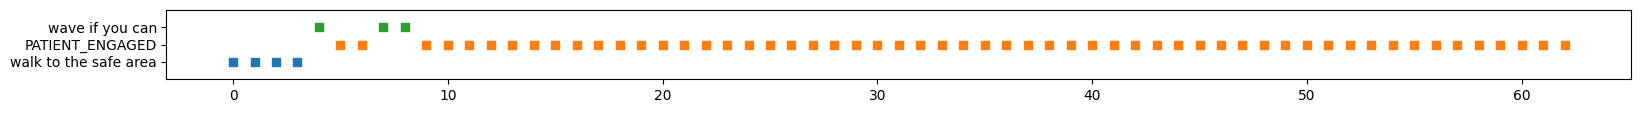

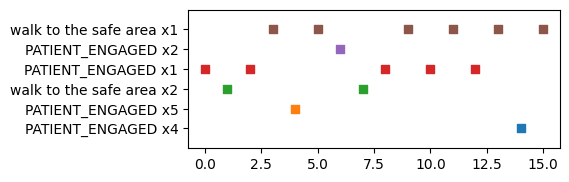

In [9]:

# Plot the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plt = plot_sequence(sequence);

# Plot the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plt = plot_sequence(sequence);

In [10]:

def count_ngrams(actions_list, highlighted_ngrams):
    '''
    Counts how many times a given sequence of elements occurs in a list.
    
    Args:
        actions_list: A list of elements.
        highlighted_ngrams: A sequence of elements to count.
    
    Returns:
        The number of times the given sequence of elements occurs in the list.
    '''
    count = 0
    for i in range(len(actions_list) - len(highlighted_ngrams) + 1):
        if (actions_list[i:i + len(highlighted_ngrams)] == highlighted_ngrams): count += 1
        
    return count

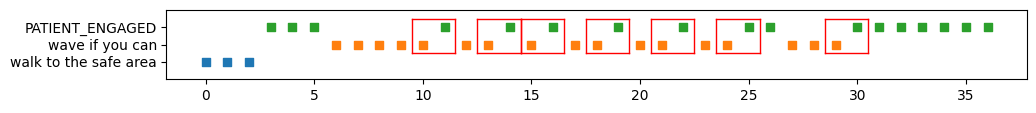

In [11]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['wave if you can', 'PATIENT_ENGAGED']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]

plot_sequence(sequence, highlighted_ngrams=[highlighted_ngrams], verbose=False);

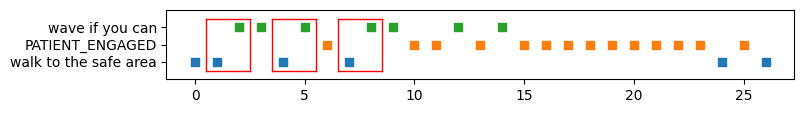

In [12]:

# Get the sequence with the highest number of ngrams
highlighted_ngrams = ['walk to the safe area', 'wave if you can']
sequence = sorted(time_groups_dict.values(), key=lambda actions_list: count_ngrams(actions_list, highlighted_ngrams), reverse=True)[0]

plot_sequence(sequence, highlighted_ngrams=[highlighted_ngrams], verbose=False);

In [13]:

def get_sequences_by_count(tg_dict, count=4):
    
    # Count the lengths of sequences in the dictionary to convert the sequence lengths list
    # into a pandas series to get the value counts of unique sequence lengths
    value_counts = pd.Series([len(actions_list) for actions_list in tg_dict.values()]).value_counts()
    
    # Filter value counts to show only counts of count to get the desired sequence length of exactly count sequences from the dictionary
    sequences = [
        actions_list for actions_list in tg_dict.values() if (len(actions_list) == value_counts[value_counts == count].index.tolist()[0])
    ]

    return sequences

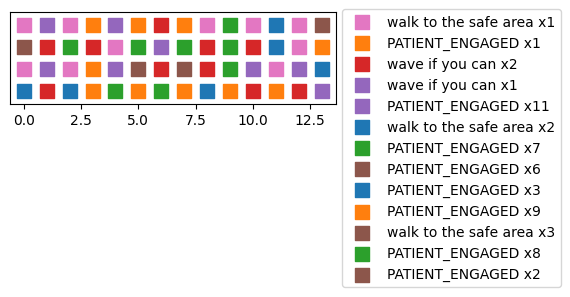

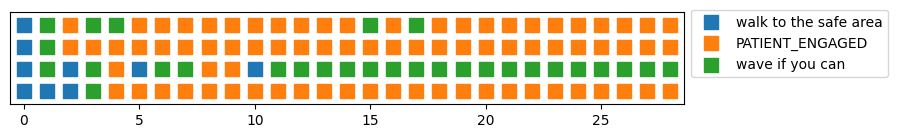

In [14]:

from pysan.multi import plot_sequences

# Get 4 sequences from the consecutive time groups dictionary
sequences = get_sequences_by_count(consecutive_time_groups_dict, count=4)

# Plot the consecutive time group sequences side-by-side
plot_sequences(sequences);

# Get 4 sequences from the time groups dictionary
sequences = get_sequences_by_count(time_groups_dict, count=4)

# Plot the time group sequences side-by-side
plot_sequences(sequences);

In [15]:

# from pysan.core import plot_sequence_1d

def plot_sequence_1d(sequence, flat=False):
    '''
    Plots a sequence in one dimension - useful for stacking multiple sequences above one another.
    
    Parameters:
        sequence (list): A sequence of elements.
        flat (bool, optional): If True, the sequence will be plotted as a flat line. Otherwise, the sequence will be plotted as a stacked bar chart.
                               Default is False.
    Returns:
        matplotlib.pyplot: The plot object representing the 1D sequence plot.

    Note:
    The input sequence can contain any hashable values (numbers, strings, etc.).
    '''
    
    # Convert the sequence to a NumPy array
    np_sequence = np.array(sequence) if not flat else np.array(sequence).flatten()
    
    # Calculate the length of the alphabet (unique values) in the sequence
    alphabet_len = len(set(sequence))
    
    # Create a figure with appropriate dimensions based on the sequence length
    plt.figure(figsize=[len(sequence)*0.4, 0.5])
    
    # Extract unique values from the sequence
    unique_values = list(set(sequence))
    
    # Iterate over the unique values and plot them as bars
    for i, value in enumerate(unique_values):
        
        # Create a list of points, where the value is 1 for occurrences of the current value and NaN for all other values
        points = np.where(np_sequence == value, 1, np.nan)
        
        # Plot the bar
        plt.bar(range(len(points)), points, width=1, align='edge', label=value)
    
    # Set y-axis limits, remove y-axis ticks and labels, and add legend
    plt.ylim(-0.3, 1.3)
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        labelleft=False
    )
    plt.xlabel('Position, p')
    plt.legend(bbox_to_anchor=(1, 1.2), loc='upper left')
    
    # Return the plot object
    return plt

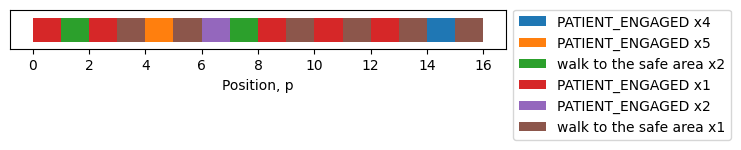

In [16]:

# Plot the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plt = plot_sequence_1d(sequence);

# Element Descriptions

> Describe elements within sequences

In [17]:

from pysan.elements import get_alphabet

# Display the alphabet of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_alphabet(sequence))

# Display the alphabet of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_alphabet(sequence))

{'walk to the safe area', 'PATIENT_ENGAGED', 'wave if you can'}

{'PATIENT_ENGAGED x4', 'PATIENT_ENGAGED x5', 'walk to the safe area x2', 'PATIENT_ENGAGED x1', 'PATIENT_ENGAGED x2', 'walk to the safe area x1'}

In [18]:

from pysan import get_element_counts

# Get the element counts of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_element_counts(sequence))

# Get the element counts of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_element_counts(sequence))

{'walk to the safe area': 4, 'PATIENT_ENGAGED': 56, 'wave if you can': 3}

{'PATIENT_ENGAGED x4': 1, 'PATIENT_ENGAGED x5': 1, 'walk to the safe area x2': 2, 'PATIENT_ENGAGED x1': 5, 'PATIENT_ENGAGED x2': 1, 'walk to the safe area x1': 6}

In [19]:

from pysan.elements import get_first_positions

# Get the first positions of each element of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_first_positions(sequence))

# Get the first positions of each element of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_first_positions(sequence))

{'walk to the safe area': 0, 'PATIENT_ENGAGED': 5, 'wave if you can': 4}

{'PATIENT_ENGAGED x4': 14, 'PATIENT_ENGAGED x5': 4, 'walk to the safe area x2': 1, 'PATIENT_ENGAGED x1': 0, 'PATIENT_ENGAGED x2': 6, 'walk to the safe area x1': 3}

In [20]:

from pysan.elements import get_element_frequency

# Get the element frequencies of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_element_frequency(sequence))

# Get the element frequencies of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_element_frequency(sequence))

{'walk to the safe area': 0.06349206349206349, 'PATIENT_ENGAGED': 0.8888888888888888, 'wave if you can': 0.047619047619047616}

{'PATIENT_ENGAGED x4': 0.0625, 'PATIENT_ENGAGED x5': 0.0625, 'walk to the safe area x2': 0.125, 'PATIENT_ENGAGED x1': 0.3125, 'PATIENT_ENGAGED x2': 0.0625, 'walk to the safe area x1': 0.375}

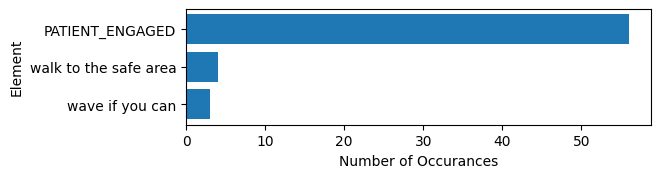

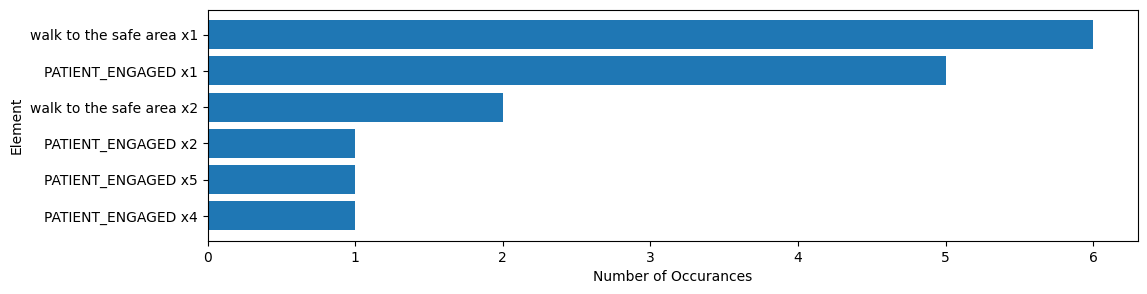

In [21]:

from pysan import plot_element_counts

# Plot the number of occurences of each element of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_element_counts(sequence);

# Plot the number of occurences of each element of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_element_counts(sequence);

# Subsequences

> Describe high-level subsequences

In [22]:

from pysan import get_subsequences

# Get the subsequences of the time groups sequence with a length of three
sequence = sorted(time_groups_dict.values(), key=lambda x: (len(x) == 3))[-1]
display(get_subsequences(sequence))

# Get the subsequences of the consecutive time groups sequence with a length of three
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: (len(x) == 3))[-1]
display(get_subsequences(sequence))

[['walk to the safe area'], ['walk to the safe area'], ['PATIENT_ENGAGED'], ['walk to the safe area', 'walk to the safe area'], ['walk to the safe area', 'PATIENT_ENGAGED'], ['walk to the safe area', 'PATIENT_ENGAGED'], ['walk to the safe area', 'walk to the safe area', 'PATIENT_ENGAGED']]

[['walk to the safe area x1'], ['wave if you can x1'], ['PATIENT_ENGAGED x20'], ['walk to the safe area x1', 'wave if you can x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x20'], ['wave if you can x1', 'PATIENT_ENGAGED x20'], ['walk to the safe area x1', 'wave if you can x1', 'PATIENT_ENGAGED x20']]

In [23]:

# from pysan import get_ndistinct_subsequences

def get_ndistinct_subsequences(sequence):
    
    # This implementation works on strings, so parse non-strings to strings
    if (type(sequence) is not str) and (not all([(len(str(e)) == 1) for e in sequence])):
        new_sequence, string_to_integer_map = convert_strings_to_integers(sequence, alphabet_list=None)
        sequence = []
        for e in new_sequence:
            sequence.append(str(e))

    # Create an array to store index of last
    last = [-1 for i in range(256 + 1)] # hard-coded value needs explaining -ojs

    # Length of input string
    sequence_length = len(sequence)

    # dp[i] is going to store count of discount subsequence of length of i
    dp = [-2 for i in range(sequence_length + 1)]

    # Empty substring has only one subseqence
    dp[0] = 1

    # Traverse through all lengths from 1 to n 
    for i in range(1, sequence_length + 1):

        # Number of subseqence with substring str[0...i-1]
        dp[i] = 2 * dp[i - 1]

        # If current character has appeared before, then remove all subseqences ending with previous occurrence
        if last[ord(sequence[i - 1])] != -1: dp[i] = dp[i] - dp[last[ord(sequence[i - 1])]]

        last[ord(sequence[i - 1])] = i - 1

    return dp[sequence_length]

In [24]:

# Get the number of distinct subsequences in the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ndistinct_subsequences(sequence))

# Get the number of distinct subsequences in the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ndistinct_subsequences(sequence))

3320

20308

# Ngrams

> Explore ngrams in a sequence

In [25]:

from pysan.ngrams import get_unique_ngrams

# Create a list of all unique ngrams found in the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_unique_ngrams(sequence, 3))

# Create a list of all unique ngrams found in the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_unique_ngrams(sequence, 3))

[['walk to the safe area', 'walk to the safe area', 'walk to the safe area'], ['walk to the safe area', 'walk to the safe area', 'wave if you can'], ['walk to the safe area', 'wave if you can', 'PATIENT_ENGAGED'], ['wave if you can', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'wave if you can'], ['PATIENT_ENGAGED', 'wave if you can', 'wave if you can'], ['wave if you can', 'wave if you can', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED']]

[['PATIENT_ENGAGED x1', 'walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['walk to the safe area x2', 'PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1', 'PATIENT_ENGAGED x5'], ['walk to the safe area x1', 'PATIENT_ENGAGED x5', 'walk to the safe area x1'], ['PATIENT_ENGAGED x5', 'walk to the safe area x1', 'PATIENT_ENGAGED x2'], ['walk to the safe area x1', 'PATIENT_ENGAGED x2', 'walk to the safe area x2'], ['PATIENT_ENGAGED x2', 'walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1', 'PATIENT_ENGAGED x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1', 'PATIENT_ENGAGED x4'], ['walk to the safe area x1', 'PATIENT_ENGAGED x4', 'walk to the safe area x1']]

In [26]:

from pysan import get_all_ngrams

# Create a list of all ngrams found in the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_all_ngrams(sequence, 2))

# Create a list of all ngrams found in the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_all_ngrams(sequence, 2))

[['walk to the safe area', 'walk to the safe area'], ['walk to the safe area', 'walk to the safe area'], ['walk to the safe area', 'walk to the safe area'], ['walk to the safe area', 'wave if you can'], ['wave if you can', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'wave if you can'], ['wave if you can', 'wave if you can'], ['wave if you can', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'PATIENT_ENGAGED'

[['PATIENT_ENGAGED x1', 'walk to the safe area x2'], ['walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x5'], ['PATIENT_ENGAGED x5', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x2'], ['PATIENT_ENGAGED x2', 'walk to the safe area x2'], ['walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x4'], ['PATIENT_ENGAGED x4', 'walk to the safe area x1']]

In [27]:

from pysan import get_ngram_universe

# Compute the universe of possible ngrams of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ngram_universe(sequence, 2))

# Compute the universe of possible ngrams of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ngram_universe(sequence, 2))

9

36

In [28]:

from pysan import get_ngram_counts

# Compute the prevalence of ngrams of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ngram_counts(sequence, 2))

# Compute the prevalence of ngrams of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ngram_counts(sequence, 2))

{"['walk to the safe area', 'walk to the safe area']": 3, "['walk to the safe area', 'wave if you can']": 1, "['wave if you can', 'PATIENT_ENGAGED']": 2, "['PATIENT_ENGAGED', 'PATIENT_ENGAGED']": 54, "['PATIENT_ENGAGED', 'wave if you can']": 1, "['wave if you can', 'wave if you can']": 1}

{"['PATIENT_ENGAGED x1', 'walk to the safe area x2']": 1, "['walk to the safe area x2', 'PATIENT_ENGAGED x1']": 2, "['PATIENT_ENGAGED x1', 'walk to the safe area x1']": 4, "['walk to the safe area x1', 'PATIENT_ENGAGED x5']": 1, "['PATIENT_ENGAGED x5', 'walk to the safe area x1']": 1, "['walk to the safe area x1', 'PATIENT_ENGAGED x2']": 1, "['PATIENT_ENGAGED x2', 'walk to the safe area x2']": 1, "['walk to the safe area x1', 'PATIENT_ENGAGED x1']": 2, "['walk to the safe area x1', 'PATIENT_ENGAGED x4']": 1, "['PATIENT_ENGAGED x4', 'walk to the safe area x1']": 1}

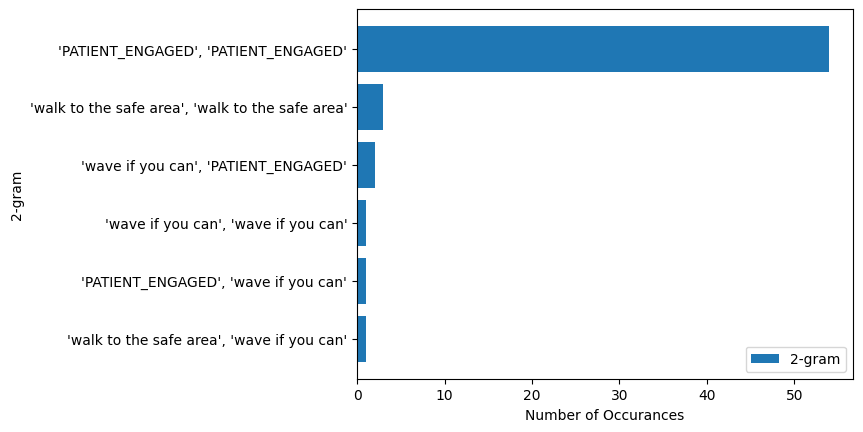

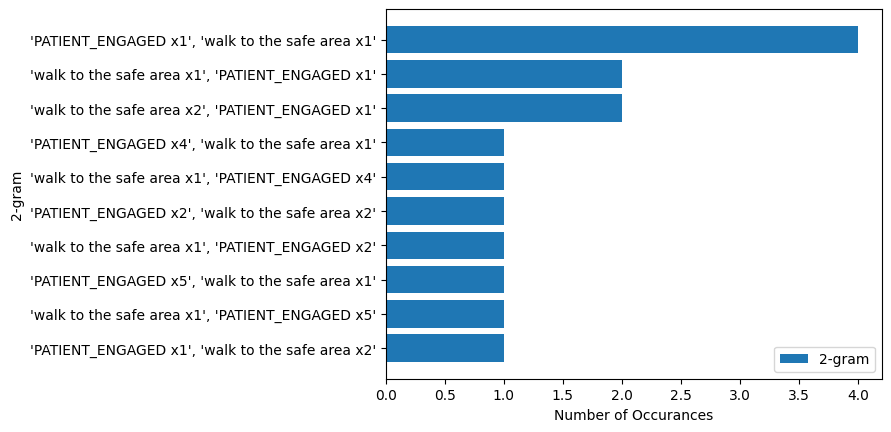

In [29]:

from pysan.ngrams import plot_ngram_counts

# Plot the number of occurances of ngrams of the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_ngram_counts(sequence, 2);

# Plot the number of occurances of ngrams of the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_ngram_counts(sequence, 2);

# Transitions

> Describe transitions between states

In [30]:

from pysan import get_transitions

# Get the number of distinct subsequences in the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_transitions(sequence))

# Get the number of distinct subsequences in the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_transitions(sequence))

[['walk to the safe area', 'wave if you can'], ['wave if you can', 'PATIENT_ENGAGED'], ['PATIENT_ENGAGED', 'wave if you can'], ['wave if you can', 'PATIENT_ENGAGED']]

[['PATIENT_ENGAGED x1', 'walk to the safe area x2'], ['walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x5'], ['PATIENT_ENGAGED x5', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x2'], ['PATIENT_ENGAGED x2', 'walk to the safe area x2'], ['walk to the safe area x2', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x1'], ['PATIENT_ENGAGED x1', 'walk to the safe area x1'], ['walk to the safe area x1', 'PATIENT_ENGAGED x4'], ['PATIENT_ENGAGED x4', 'walk to the safe area x1']]

In [31]:

from pysan import get_ntransitions

# Get the number of distinct subsequences in the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ntransitions(sequence))

# Get the number of distinct subsequences in the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
display(get_ntransitions(sequence))

4

15

In [5]:
#export
from pysan.elements import get_alphabet
from pysan.ngrams import get_all_ngrams
import numpy as np, pandas as pd
def get_transition_matrix(sequence, alphabet=None, verbose=False):
    "Computes a transition matrix for each bigram in a sequence. The resulting matrix can be interpreted by reading along the side first, then across the top, indicating from the element down the side, to the element along the top. For example, to find the number of transitions from element 2 to element 3, find element 2 down the side, then follow that row across until it reaches element 3 across the top."
    if alphabet == None:
        alphabet = get_alphabet(sequence)
    all_ngrams = get_all_ngrams(sequence, 2)

    transition_matrix = np.zeros((len(alphabet), len(alphabet)))
    descriptive_matrix = [['-' for x in range(len(alphabet))] for y in range(len(alphabet))]

    for x, element_row in enumerate(alphabet):
        for y, element_column in enumerate(alphabet):
            current_ngram = [element_row, element_column]
            descriptive_matrix[x][y] = 'n' + str(current_ngram)
            #print('from', current_ngram[0], 'to', current_ngram[1], ':', all_ngrams.count(current_ngram))
            transition_matrix[x, y] = all_ngrams.count(current_ngram)

    # add column & index labelling in TraMineR style
    pre_alphabet = [str(a) + '->' for a in alphabet]
    post_alphabet = ['->' + str(a) for a in alphabet]

    if verbose:
        de_df = pd.DataFrame(descriptive_matrix, columns=post_alphabet, index=pre_alphabet)
        print(de_df)
    tm_df = pd.DataFrame(transition_matrix, columns=post_alphabet, index=pre_alphabet)
    return tm_df

In [32]:

from pysan.transitions import get_transition_matrix
# from pysan import plot_transition_matrix

def plot_transition_matrix(sequence, cmap='summer'):
    '''
    Computes and plots a transition matrix, returning a colored matrix
    with elements at position n up the y axis,
    and elements at position n+1 along the x axis.
    '''

    matrix = get_transition_matrix(sequence)

    results_size = len(matrix.columns)
    values = np.empty((results_size, results_size), dtype=object)

    for r, row in enumerate(matrix.values):
        for e, element in enumerate(row):
            if element == '-':
                values[r, e] = 100
                continue
            if element == '':
                values[r, e] = np.nan
                continue
            if '*' in str(element):
                value = element.replace('*', '')
                values[r, e] = float(value)
            else: values[r, e] = element

    current_cmap = copy.copy(cm.get_cmap(cmap))
    current_cmap.set_bad(color='white')

    plt.figure()

    # this one-lines sets the x axis to appear at the top of this plot only
    with plt.rc_context({'xtick.bottom':False, 'xtick.labelbottom':False, 'xtick.top':True, 'xtick.labeltop':True}):
        ax = plt.gca()
        ax.xaxis.set_label_position('top')
        plt.imshow(np.array(values).astype(float), cmap=current_cmap)

        plt.yticks(range(len(matrix.index)), list(matrix.index))
        plt.xticks(range(len(matrix.columns)), list(matrix.columns), rotation=90)
        cbar = plt.colorbar()
        plt.grid(False)
        
        return plt

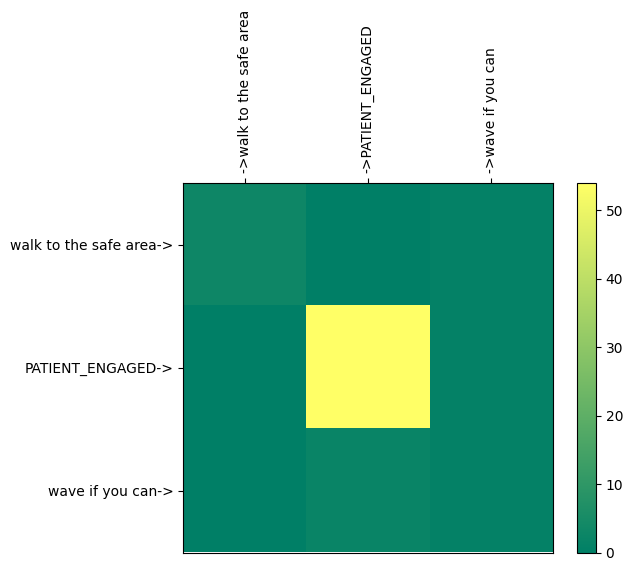

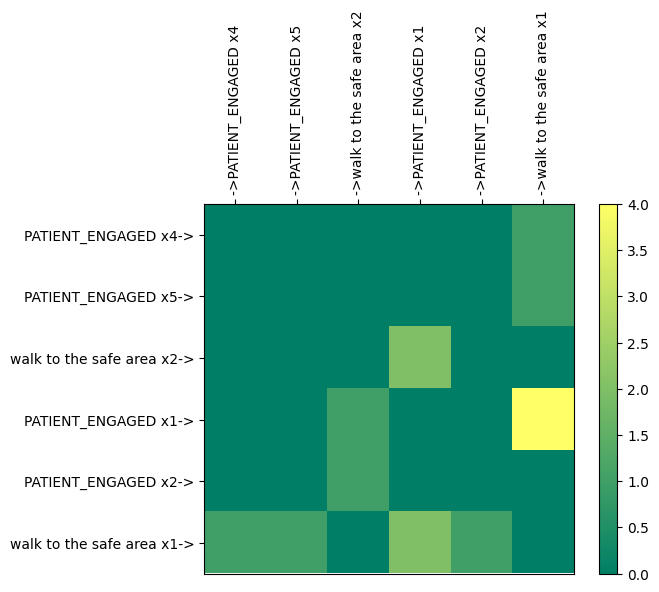

In [33]:

# Plot the time groups sequence with the greatest length
sequence = sorted(time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_transition_matrix(sequence);

# Plot the consecutive time groups sequence with the greatest length
sequence = sorted(consecutive_time_groups_dict.values(), key=lambda x: len(x), reverse=True)[0]
plot_transition_matrix(sequence);